# TCR FLOWER PLOT
**Author: Juan Sebastian Diaz Boada**<br>
*juan.sebastian.diaz.boada@ki.se*<br>
26/01/22<br>
Kernel: `network_ravi`<br>

In [1]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from polyleven import levenshtein as poly_lev
from collections import defaultdict
import igraph as ig
import random # layout seed
import cairo as cr
from igraph.drawing.text import TextDrawer
from math import pi # Legend circles
import blosum as bl

In [2]:
module_path = os.path.abspath(os.path.join('..', 'bin'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# from ../bin
import spring_functions as kxs
from data_functions import group_with_freq

## Parameters

In [4]:
pd.set_option('display.max_columns',None)

#### Data parameters

In [5]:
in_file = '../data/network_data.csv'
file_type = in_file.split('.')[-1]
if file_type == 'tsv':
    DF = pd.read_csv(in_file,sep='\t',index_col=0).reset_index(drop=True)
elif file_type == 'xlsx':
    DF = pd.read_excel(in_file,index_col=0)
elif file_type == 'csv':
    DF = pd.read_csv(in_file,sep=',',index_col=0).reset_index(drop=True)
else:
    raise NameError("Invalid input format. Has to be either .tsv, .csv or .xlsx.")

In [6]:
out_file = '../results/NETWORK_PLOT.pdf'
seq_col = 'aaSeqCDR3.xy'
color_col = 'Sort_platform'
shape_col = 'Site'
size_col = 'minQualFR4.y'
min_seq2show = 0 # integer
group_unique = True # Boolean

#### Figure parameters

In [7]:
# Similarity threshold
similarity = 0 # non-negative integer
layout_name = 'FR' # Can be FR, DH, DrL, GO, LgL, MDS
unit=50
edge_width = 1.5
max_node_size=50
min_node_size=5

# Data

In [36]:
df = DF.copy()
df

,aaSeqCDR3.xy,Site,HLA_type,Sort_platform,minQualFR4.y
0,CAVSDDKIIFCASSQGVGEYTDTQYF,PB,*04:04,SONY SH800,23
1,CARPPLRDTGNQFYFCASSEQEGIRQFF,SF,*04:04,INFLUX,22
2,CAVRDLLEGQNFVFCASSLGTEEIYEQYF,SF,*04:04,INFLUX,24
3,CALREWMDSSYKLIFCASTQDLNPGTEQFF,SF,*04:04,Influx,15
4,CAVEDTDSWGKLQFCASSRQEGNSPLHF,SF,*04:04,Influx,21
...,...,...,...,...,...
245,CAMLGFSDGQKLLFCASSLLTGARYGYTF,PB,*04:04,Influx,26
246,CAMLGFSDGQKLLFCASSLLTGARYGYTF,PB,*04:04,Influx,23
247,CAMLGFSDGQKLLFCASSLLTGARYGYTF,PB,*04:04,Influx,22
248,CAMLGFSDGQKLLFCASSLLTGARYGYTF,PB,*04:04,Influx,15


In [ ]:
df.insert(len(df.columns),'node_size',35)
df.loc[df['freq_Sequence']<30,'node_size']=30
df.loc[df['freq_Sequence']<15,'node_size']=25
df.loc[df['freq_Sequence']<5,'node_size']=20
df.loc[df['freq_Sequence']==1,'node_size']=10
df

In [37]:
df = group_with_freq(df,seq_col,group_unique).sort_values('freq_'+seq_col,ascending=False)
#df = df.loc[df['freq_'+seq_col]!=1,:]
df

,aaSeqCDR3.xy,Site,HLA_type,Sort_platform,minQualFR4.y,freq_aaSeqCDR3.xy,group_aaSeqCDR3.xy
180,CAASENYGQNFVFCASTTGTTYGYTF,PB,*04:04,Sony SH800,23,29,0
203,CAASENYGQNFVFCASTTGTTYGYTF,PB,*04:04,Sony SH800,23,29,0
182,CAASENYGQNFVFCASTTGTTYGYTF,PB,*04:04,Sony SH800,23,29,0
227,CAASENYGQNFVFCASTTGTTYGYTF,PB,*04:04,Sony SH800,23,29,0
225,CAASENYGQNFVFCASTTGTTYGYTF,PB,*04:04,Sony SH800,24,29,0
...,...,...,...,...,...,...,...
147,CAVNEGTYKYIFCASSLGTGGGETQYF,PB,*04:04,Sony SH800,16,1,-1
137,CAVNEGTYKYIFCASSQEREGPTGELFF,PB,*04:04,Sony SH800,18,1,-1
2,CAVRDLLEGQNFVFCASSLGTEEIYEQYF,SF,*04:04,INFLUX,24,1,-1
91,CAVRVNTGRRALTFCASSPRQGLQETQYF,PB,*04:04,Sony SH800,21,1,-1


In [135]:
df.loc[:,'group_'+seq_col].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  8,  7, 10,  9, 11, 14, 15, 13, 12, 21,
       26, 25, 24, 23, 22, 18, 20, 16, 17, 19, -1])

# II. Distance matrix calculation

In [38]:
seqs = df[seq_col].values
#idx2seq = {i:seq for i,seq in enumerate(seqs)}
L = len(seqs)
dist = np.zeros([L,L])
t = np.ceil(L/100)
for i in range(L):
    for j in range(L):
        dist[i,j]=poly_lev(seqs[i],seqs[j])
    if i%t==0:
        print("%.2f %% completed"%(i*100/L))

0.00 % completed
1.20 % completed
2.40 % completed
3.60 % completed
4.80 % completed
6.00 % completed
7.20 % completed
8.40 % completed
9.60 % completed
10.80 % completed
12.00 % completed
13.20 % completed
14.40 % completed
15.60 % completed
16.80 % completed
18.00 % completed
19.20 % completed
20.40 % completed
21.60 % completed
22.80 % completed
24.00 % completed
25.20 % completed
26.40 % completed
27.60 % completed
28.80 % completed
30.00 % completed
31.20 % completed
32.40 % completed
33.60 % completed
34.80 % completed
36.00 % completed
37.20 % completed
38.40 % completed
39.60 % completed
40.80 % completed
42.00 % completed
43.20 % completed
44.40 % completed
45.60 % completed
46.80 % completed
48.00 % completed
49.20 % completed
50.40 % completed
51.60 % completed
52.80 % completed
54.00 % completed
55.20 % completed
56.40 % completed
57.60 % completed
58.80 % completed
60.00 % completed
61.20 % completed
62.40 % completed
63.60 % completed
64.80 % completed
66.00 % completed
6

In [39]:
# Definite adjacency and weight matrices
eps = 0.1 # Distance delta
adj = dist.copy()
adj[adj<=similarity]=-1
adj[adj>similarity]=0
adj[adj==-1]=1
W = np.multiply(adj,dist+eps)

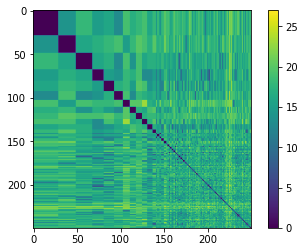

In [40]:
plt.imshow(dist)
plt.colorbar()

# III. Graph generation and plotting

In [127]:
# Create graph object
g = ig.Graph.Weighted_Adjacency(W,mode='undirected',attr='distance',loops=False)

In [131]:
g.get_vertex_dataframe()

,plot_cluster,freq_cluster,plot_cluster_reduced
vertex ID,,,
0,0,29,0
1,0,29,0
2,0,29,0
3,0,29,0
4,0,29,0
...,...,...,...
245,97,1,27
246,98,1,27
247,99,1,27


### Node metadata

In [129]:
# Assigns a cluster value based on connected subgraphs. Useful for spring weight
g.vs['plot_cluster'] = g.clusters('strong').membership
# Add its frequency
cluster_series = g.get_vertex_dataframe().loc[:,'plot_cluster']
g.vs['freq_cluster'] = cluster_series.map(cluster_series.value_counts())

In [130]:
# Create the reduced cluster number, which groups together all disconnected sequences
VDF = g.get_vertex_dataframe().sort_values('freq_cluster',ascending=False)
repeated_seqs = VDF.loc[VDF['freq_cluster']!=1,'plot_cluster'].factorize()[0]
single_seqs = (max(repeated_seqs)+1)*\
                np.ones([len(VDF.loc[VDF['freq_cluster']==1,'plot_cluster'])],dtype=int)
VDF['plot_cluster_reduced'] = np.concatenate([repeated_seqs,single_seqs])
g.vs['plot_cluster_reduced'] = VDF.loc[:,'plot_cluster_reduced']

### Node color
Define the fields `plot_label`, which will be the label in the legend of the plot, and `color` for each node. Depending on the type of label, the colouring and the labels will be different.

In [121]:
# Assign a feature to color plot
color_label = df.loc[:,color_col].values
## COLOR PALETTE ##
# Define unique group labels
_, idx = np.unique(color_label,return_index=True)
labs = color_label[np.sort(idx)]
n_labs = len(labs)
# Create color pallete based on number of groups
pal = ig.drawing.colors.ClusterColoringPalette(n_labs)
label2RGB = {l:pal.get_many(c)[0] for c,l in enumerate(labs)} # Numbering each label
g.vs['color'] = [label2RGB[l] for l in color_label]

### Node shape

In [122]:
shapes = ['circle','rectangle','triangle-up','triangle-down','diamond']

In [123]:
shape_labels = df[shape_col].unique()
n_shapes = len(shape_labels)
if n_shapes > 5:
    raise ValueError('There can not be more than 5 shapes.')
else:
    shapes = shapes[:n_shapes]
    shape_dic = {shape_labels[i]:shapes[i] for i in range(n_shapes)}

In [124]:
g.vs['shape'] = df.loc[:,shape_col].replace(shape_dic)

### Node size

In [125]:
if size_col==None:
    s = 20
else:
    s = df[size_col].values
    s = (s-np.min(s))/(np.max(s)-np.min(s))*(max_node_size-min_node_size)+min_node_size
g.vs['size'] = s

### Edge metadata

In [103]:
g.get_edge_dataframe()

,source,target,distance
edge ID,,,
0,0,1,0.1
1,0,2,0.1
2,0,3,0.1
3,0,4,0.1
4,0,5,0.1
...,...,...,...
1080,165,171,0.1
1081,166,174,0.1
1082,167,168,0.1


In [104]:
g.get_edge_dataframe().loc[:,'distance'].unique()

array([0.1])

In [100]:
edges_array = np.array(g.get_edgelist()) # list of edges (node,node)
# Distance of every edge according to the distance matrix
edge_dist = np.array([dist[tuple(i)] for i in edges_array])
# Edge atributes
g.es['distance'] = edge_dist
g.es['width'] = [edge_width if (edge['distance']==0 ) else edge_width/2 for edge in g.es]
g.es['color'] = ["black" if (edge['distance']>0 ) else "red" for edge in g.es]

### Graph layout
Creates a layout with the algorithm given by the keyword `layout_name` 

In [105]:
# Initialize layout with a seed (reproducibility)
random.seed(42)
np.random.seed(42)
layout_seed = np.random.random([len(g.vs),2])

# ToDo: Implement MDS and LgL

In [106]:
# Reingold-Fruchterman
if layout_name == 'FR':
    niter = 5000
    weights = kxs.prop_log_weights(g)
    g.es['weights'] = weights
    l = g.layout_fruchterman_reingold(weights=weights,\
                                      seed=layout_seed,niter=niter)
# Davidson-Harel
elif layout_name == 'DH':
    maxiter = 80
    fineiter = 15
    cool_fact = 0.95
    weight_node_dist = 1000
    weight_border = 20000000
    weight_edge_lengths = 0.1
    weight_edge_crossings = 1000
    weight_node_edge_dist = 10000
    l = g.layout_davidson_harel(seed=layout_seed, maxiter=maxiter, fineiter=fineiter,\
                                       cool_fact=cool_fact, weight_node_dist=weight_node_dist,\
                                       weight_border=weight_border,\
                                       weight_edge_lengths=weight_edge_lengths,\
                                       weight_edge_crossings=weight_edge_crossings,\
                                       weight_node_edge_dist=weight_node_edge_dist)
# Graphopt
elif layout_name == 'GO':
    niter = 500
    node_charge = 0.03
    node_mass = 5
    spring_length = 5
    spring_constant = 0.5
    max_sa_movement = 12
    l = g.layout_graphopt(niter=niter, node_charge=node_charge, node_mass=node_mass,\
                          spring_length=spring_length, spring_constant=spring_constant,\
                          max_sa_movement=max_sa_movement, seed=layout_seed)

KeyError: 'plot_cluster_reduced'

#### Plot generation

In [ ]:
visual_style = {
    'bbox' : (0, 0, 600, 600),
    'layout' : l,
    "margin": 20,
    "autocurve" : False,
    'edge_width' : g.es['width'],
    'vertex_size' : g.vs['size']
}
ig.plot(g,target=fig_name,**visual_style)

### Plotting with legend

In [ ]:
label_h = 0.4*unit
width,height = (24*unit,18*unit)

In [ ]:
# Construct the plot
plot = ig.Plot(fig_name, bbox=(width,height), background="white")
plot.add(g, bbox=(1*unit, 1*unit, width-7*unit, height-1*unit),\
         vertex_size=g.vs['size'],layout=l)
# Make the plot draw itself on the Cairo surface
plot.redraw()
# Grab the surface, construct a drawing context
ctx = cr.Context(plot.surface)
# Legend rectangle
rect_height = label_h*len(label2RGB) + label_h
rect_width = 3*unit # Change if the label is too long/short
coord = [19*unit,9*unit-rect_height/2] # standing coordinates x,y

ctx.rectangle(coord[0],coord[1], rect_width, rect_height)
ctx.set_source_rgb(1, 1, 1)
ctx.fill_preserve()
ctx.set_source_rgb(0, 0, 0)
ctx.set_line_width(2)
ctx.stroke()

# Legend items
coord[0]=coord[0]+label_h
for l in label2RGB.keys():
    # Circle
    coord[1] = coord[1] + label_h
    ctx.move_to(coord[0],coord[1])
    ctx.arc(coord[0],coord[1], 0.1*unit, 0, 2*pi)
    ctx.close_path()
    ctx.set_source_rgb(label2RGB[l][0],label2RGB[l][1],label2RGB[l][2]) #R,G,B
    ctx.fill()
    # Text
    ctx.set_source_rgb(0, 0, 0)
    ctx.set_font_size(0.3*unit)
    ctx.select_font_face("Arial",
                         cr.FONT_SLANT_NORMAL,
                         cr.FONT_WEIGHT_NORMAL)
    ctx.move_to(coord[0]+0.3*unit,coord[1]+0.1*unit)
    ctx.show_text(l)

# Save the plot
plot.save(fig_name)